# CMPE255 Project

## US Traffic Accidents Dataset

We are interested in analyzing details of a traffic accident and its correlation with the **severity of the accident** and the **length of road affected by an accident**.

In [22]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, r2_score

## Data exploration

In [2]:
# Import dataset
features = pd.read_csv('US_Accidents_Dec20.csv')
features.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [3]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232541 entries, 0 to 4232540
Data columns (total 49 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   TMC                    float64
 3   Severity               int64  
 4   Start_Time             object 
 5   End_Time               object 
 6   Start_Lat              float64
 7   Start_Lng              float64
 8   End_Lat                float64
 9   End_Lng                float64
 10  Distance(mi)           float64
 11  Description            object 
 12  Number                 float64
 13  Street                 object 
 14  Side                   object 
 15  City                   object 
 16  County                 object 
 17  State                  object 
 18  Zipcode                object 
 19  Country                object 
 20  Timezone               object 
 21  Airport_Code           object 
 22  Weather_Timestamp 

In [4]:
features.nunique()

ID                       4232541
Source                         3
TMC                           21
Severity                       4
Start_Time               3657563
End_Time                 3775982
Start_Lat                1371599
Start_Lng                1371288
End_Lat                   587824
End_Lng                   599916
Distance(mi)               14619
Description              2166721
Number                     43868
Street                    210786
Side                           3
City                       12250
County                      1752
State                         49
Zipcode                   494306
Country                        1
Timezone                       4
Airport_Code                2022
Weather_Timestamp         616787
Temperature(F)               840
Wind_Chill(F)                984
Humidity(%)                  100
Pressure(in)                1041
Visibility(mi)                87
Wind_Direction                24
Wind_Speed(mph)              162
Precipitat

## Data analysis / plots


In [5]:
# Heatmap of correlation
plt.figure(figsize=(20, 14))
corr = features.corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

## Data preprocessing

There are many features that immediately do not tell us much about an accident, such as the **Accident ID** and **Source** from which the data was retrieved from. There are some features that are also redundant or have only 1 value in the entire dataset, such as **Country** and **Turning_Loop**. There are also features with too many missing values, such as **Wind_Chill(F)**. As such, we will be dropping these features. 

In [6]:
# Drop features
to_drop = ['ID', 
           'Source', 
           'TMC', 
           'End_Lat', 
           'End_Lng', 
           'Description', 
           'Number', 
           'Street',
           'City',
           'County',
           'Zipcode', 
           'Country', 
           'Timezone', 
           'Airport_Code', 
           'Weather_Timestamp', 
           'Wind_Chill(F)', 
           'Precipitation(in)', 
           'Amenity', 
           'Turning_Loop', 
           'Civil_Twilight', 
           'Nautical_Twilight', 
           'Astronomical_Twilight']

features = features.drop(columns=to_drop)

In [7]:
features.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Side,State,Temperature(F),Humidity(%),...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset
0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,R,OH,36.9,91.0,...,False,False,False,False,False,False,False,False,False,Night
1,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,L,OH,37.9,100.0,...,False,False,False,False,False,False,False,False,False,Night
2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,R,OH,36.0,100.0,...,False,False,False,False,False,False,False,False,True,Night
3,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.01,R,OH,35.1,96.0,...,False,False,False,False,False,False,False,False,False,Night
4,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.01,R,OH,36.0,89.0,...,False,False,False,False,False,False,False,False,True,Day


In [8]:
# Check NAs
features.isna().sum()

Severity                  0
Start_Time                0
End_Time                  0
Start_Lat                 0
Start_Lng                 0
Distance(mi)              0
Side                      0
State                     0
Temperature(F)        89900
Humidity(%)           95467
Pressure(in)          76384
Visibility(mi)        98668
Wind_Direction        83611
Wind_Speed(mph)      479326
Weather_Condition     98383
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Sunrise_Sunset          141
dtype: int64

In [9]:
# Extract time data
features['Start_Time'] = pd.to_datetime(features['Start_Time'], errors='coerce')
features['End_Time'] = pd.to_datetime(features['End_Time'], errors='coerce')

features['Year'] = features['Start_Time'].dt.year
features['Month'] = features['Start_Time'].dt.strftime('%b')
features['Day'] = features['Start_Time'].dt.day
features['Hour'] = features['Start_Time'].dt.hour
features['Weekday'] = features['Start_Time'].dt.strftime('%a')

features['Time_Duration(min)'] = round((features['End_Time'] - features['Start_Time']) / np.timedelta64(1,'m'))

In [10]:
# Check negative time durations
duration_check = features['Time_Duration(min)'] <= 0
duration_check.unique()

array([False])

In [11]:
# Fill NAs 
features['Temperature(F)'].fillna(features['Temperature(F)'].mean(), inplace=True)
features['Humidity(%)'].fillna(features['Humidity(%)'].median(), inplace=True)
features['Pressure(in)'].fillna(features['Pressure(in)'].mean(), inplace=True)
features['Visibility(mi)'].fillna(features['Visibility(mi)'].mode()[0], inplace=True)
features['Wind_Speed(mph)'].fillna(features['Wind_Speed(mph)'].mean(), inplace=True)
features['Wind_Direction'].fillna(features['Wind_Direction'].mode()[0], inplace=True)
features['Weather_Condition'].fillna(features['Weather_Condition'].mode()[0], inplace=True)
features['Sunrise_Sunset'].fillna(features['Sunrise_Sunset'].mode()[0], inplace=True)


In [12]:
# Standardize wind direction
features['Wind_Direction'].loc[features['Wind_Direction'] == 'Calm'] = 'CALM'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'South'] = 'S'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'North'] = 'N'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'East'] = 'E'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'West'] = 'W'
features['Wind_Direction'].loc[features['Wind_Direction'] == 'Variable'] = 'VAR'

/home/benny/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [13]:
features.drop(columns=['Start_Time', 'End_Time'], inplace=True)

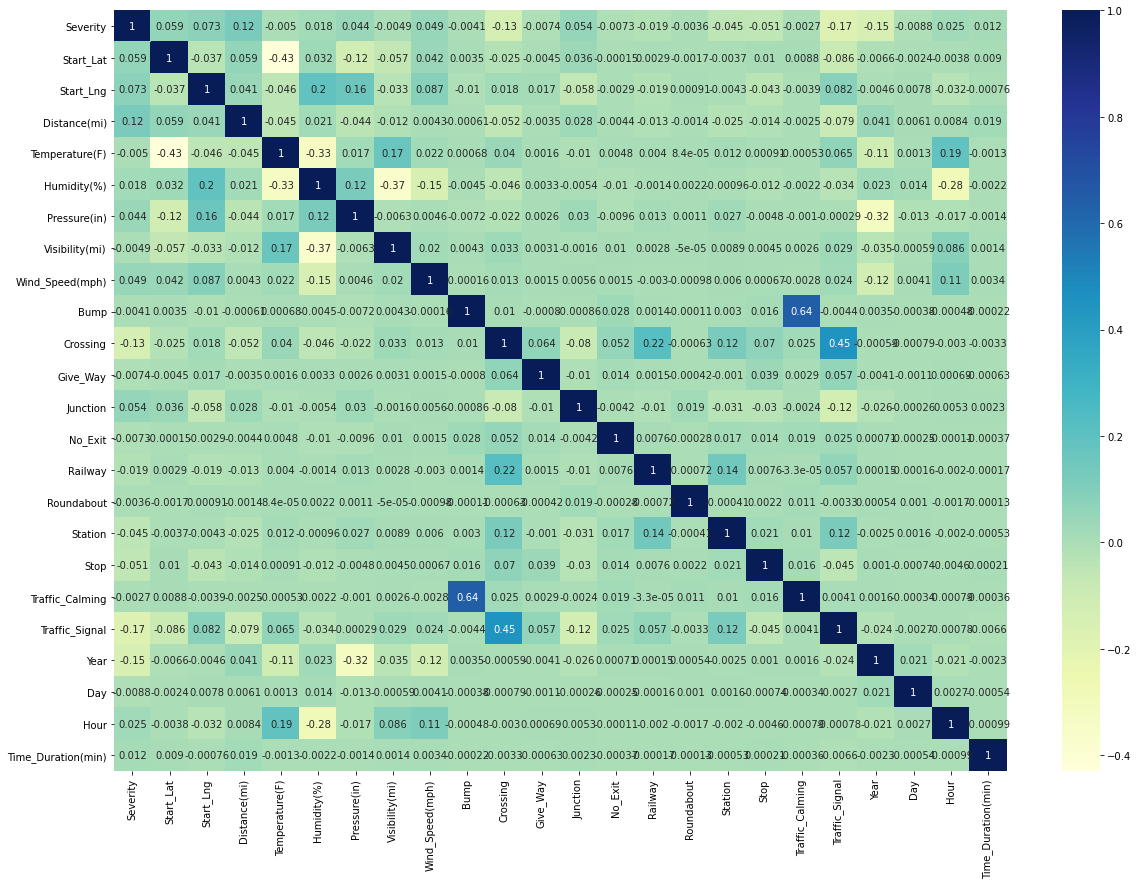

In [14]:
# Plot correlation with heatmap
plt.figure(figsize=(20, 14))
corr = features.corr()
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.show()

severity_corr = corr.abs().loc['Severity', :].sort_values(ascending=False)
distance_corr = corr.abs().loc['Distance(mi)', :].sort_values(ascending=False)

In [15]:
# Encode categorical data
enc = LabelEncoder()
features['Side'] = enc.fit_transform(features['Side'])
features['State'] = enc.fit_transform(features['State'])
features['Wind_Direction'] = enc.fit_transform(features['Wind_Direction'])
features['Weather_Condition'] = enc.fit_transform(features['Weather_Condition'])
features['Bump'] = enc.fit_transform(features['Bump'])
features['Crossing'] = enc.fit_transform(features['Crossing'])
features['Give_Way'] = enc.fit_transform(features['Give_Way'])
features['Junction'] = enc.fit_transform(features['Junction'])
features['No_Exit'] = enc.fit_transform(features['No_Exit'])
features['Railway'] = enc.fit_transform(features['Railway'])
features['Roundabout'] = enc.fit_transform(features['Roundabout'])
features['Station'] = enc.fit_transform(features['Station'])
features['Stop'] = enc.fit_transform(features['Stop'])
features['Traffic_Calming'] = enc.fit_transform(features['Traffic_Calming'])
features['Traffic_Signal'] = enc.fit_transform(features['Traffic_Signal'])
features['Sunrise_Sunset'] = enc.fit_transform(features['Sunrise_Sunset'])
features['Month'] = enc.fit_transform(features['Month'])
features['Weekday'] = enc.fit_transform(features['Weekday'])

In [16]:
features.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Side,State,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),...,Stop,Traffic_Calming,Traffic_Signal,Sunrise_Sunset,Year,Month,Day,Hour,Weekday,Time_Duration(min)
0,3,39.865147,-84.058723,0.01,2,33,36.9,91.0,29.68,10.0,...,0,0,0,1,2016,3,8,5,1,314.0
1,2,39.928059,-82.831184,0.01,1,33,37.9,100.0,29.65,10.0,...,0,0,0,1,2016,3,8,6,1,30.0
2,2,39.063148,-84.032608,0.01,2,33,36.0,100.0,29.67,10.0,...,0,0,1,1,2016,3,8,6,1,30.0
3,3,39.747753,-84.205582,0.01,2,33,35.1,96.0,29.64,9.0,...,0,0,0,1,2016,3,8,7,1,30.0
4,2,39.627781,-84.188354,0.01,2,33,36.0,89.0,29.65,6.0,...,0,0,1,0,2016,3,8,7,1,30.0


In [17]:
# Use the top k features based on correlation
k = 10
severity_df = features[severity_corr[1:k+2].index]
severity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232541 entries, 0 to 4232540
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Traffic_Signal   int64  
 1   Year             int64  
 2   Crossing         int64  
 3   Distance(mi)     float64
 4   Start_Lng        float64
 5   Start_Lat        float64
 6   Junction         int64  
 7   Stop             int64  
 8   Wind_Speed(mph)  float64
 9   Station          int64  
 10  Pressure(in)     float64
dtypes: float64(5), int64(6)
memory usage: 355.2 MB


In [18]:
distance_df = features[distance_corr[1:k+2].index]
distance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232541 entries, 0 to 4232540
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Severity        int64  
 1   Traffic_Signal  int64  
 2   Start_Lat       float64
 3   Crossing        int64  
 4   Temperature(F)  float64
 5   Pressure(in)    float64
 6   Year            int64  
 7   Start_Lng       float64
 8   Junction        int64  
 9   Station         int64  
 10  Humidity(%)     float64
dtypes: float64(5), int64(6)
memory usage: 355.2 MB


In [19]:
# Split dataset 80:20
dist_x_train, dist_x_test, dist_y_train, dist_y_test = train_test_split(distance_df, features['Distance(mi)'], test_size=0.2, random_state=1)

# Standardizing for SVM
# scaler = StandardScaler()
# scaler.fit_transform(severity_df)
sev_x_train, sev_x_test, sev_y_train, sev_y_test = train_test_split(severity_df, features['Severity'], test_size=0.2, random_state=1)

In [24]:
# Train SVM for classifying severity
# clf = RandomForestClassifier(max_depth=10, )
# scores = cross_val_score(clf, sev_x_train, sev_y_train, cv=5)
# # clf.fit(sev_x_train, sev_y_train)
# print(scores)

[0.7261694  0.72962034 0.7276235  0.72901303 0.72653077]


In [ ]:
# Make predictions on severity
# sev_pred = clf.predict(sev_x_test)
# sev_acc = accuracy_score(sev_y_test, sev_pred)
# print('Accuracy :\t', sev_acc)

In [ ]:
# Train ElasticNet for regression on distance
# regressor = ElasticNetCV(alphas=[0.25, 0.5, 0.75, 1], 
#                        l1_ratio=[0.25, 0.5, 0.75, 1],
#                        cv=5)
# regressor.fit(dist_x_train, dist_y_train)

In [ ]:
# distance_pred = regressor.predict(dist_x_test)
# distance_r2 = r2_score(dist_y_test, distance_pred)
# print('R2 score :\t', distance_r2)

In [ ]:
# Plot regression
# plt.figure(figsize=(14,10))
# scatter_x = list(range(dist_x_test.shape[0]))
# plt.scatter(scatter_x, dist_y_test, marker='.', c='blue')
# plt.scatter(scatter_x, distance_pred, marker='x', c='red')

In [ ]:
# train_acc = clf.score(sev_x_train, sev_y_train)
# print('Accuracy :\t', train_acc)